# Jupyter notebook to test the effectiveness of the CC detection models.

In [2]:
import numpy as np
import pandas as pd
import argparse

import tensorflow as tf
import sklearn as sk
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from datetime import datetime

2024-04-21 11:10:09.756444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 11:10:09.756511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 11:10:09.758940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 11:10:09.772477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 11:10:11.553646: W tensorflow/compiler/tf2

In [3]:
# Define Default values
csvfile = '../datasets/all_datasets_raw.tsv'
# Less than 5 letters is just too small to know if it is a CC or not. So we set a minimum.
min_letters = 5
# The max 500 letters is arbitrary but we believe that less than 50 letters should be enough to know if it is a CC
max_letters = 500
# In case the sequences are too long to load, is better to never load more than some amount from file to memory. A safeguard
take_last_num = lambda x: x[: max_letters]

In [4]:
# Load the dataframe from the TSV file
df = pd.read_csv(
        csvfile,
        delimiter="|",
        names=["note", "label", "model_id", "state"],
        skipinitialspace=True,
        converters={"state": take_last_num},
    )

In [5]:
# Clean the dataset
df.dropna(axis=0, how="any", inplace=True)
df.drop(axis=1, columns=["note", "model_id"], inplace=True)

In [6]:
# Delete the strings of letters with less than a certain amount
indexNames = df[df["state"].str.len() < min_letters].index
df.drop(indexNames, inplace=True)

In [7]:
# Add a new column to the dataframe with the label. The label is 'Normal' for the normal data and 'Malcious' for the malware data
df.loc[df.label.str.contains("Normal"), "label"] = "Normal"
df.loc[df.label.str.contains("Botnet"), "label"] = "Malicious"
df.loc[df.label.str.contains("Malware"), "label"] = "Malicious"

In [8]:
# Encode the label as an integer. 1 for maliciuos, 0 for benign. 
df.label = df.label.replace("Malicious", 1)
df.label = df.label.replace("Normal", 0)

/tmp/ipykernel_2343781/3015528503.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.label = df.label.replace("Normal", 0)


In [9]:
# Convert each of the stratosphere letters to an integer as an encoding. There are 50 symbols
vocabulary = list("abcdefghiABCDEFGHIrstuvwxyzRSTUVWXYZ1234567890,.+*")
int_of_letters = {}
for i, letter in enumerate(vocabulary):
    int_of_letters[letter] = float(i)
print( f"There are {len(int_of_letters)} letters in total. From letter index {min(int_of_letters.values())} to letter index {max(int_of_letters.values())}.")
vocabulary_size = len(int_of_letters)

There are 50 letters in total. From letter index 0.0 to letter index 49.0.


In [10]:
# Change the letters in the state to an integer representing it uniquely. We 'encode' them.
df["state"] = df["state"].apply(lambda x: [[int_of_letters[i]] for i in x])
# So far, only 1 feature per letter
features_per_sample = 1

In [11]:
# Check how the encoding looks like
df.state.head()

70    [[44.0], [44.0], [45.0], [17.0], [17.0], [49.0...
71    [[36.0], [36.0], [47.0], [27.0], [47.0], [27.0...
73             [[44.0], [41.0], [47.0], [14.0], [47.0]]
75    [[41.0], [41.0], [47.0], [35.0], [47.0], [26.0...
76    [[44.0], [44.0], [47.0], [35.0], [47.0], [26.0...
Name: state, dtype: object

In [12]:
# Convert the data into the appropriate shape
# x_data is a list of lists. The 1st dimension is the outtuple, the second the letter. Each letter is now an int value. shape=(num_outuples, features_per_sample)
x_data = df["state"].to_numpy()
print(f"There are {len(x_data)} outtuples")

There are 2228 outtuples


In [13]:
# y_data is a list of ints that are 0 or 1. One integer per outtupple. shape=(num_outuples, 1)
y_data = df["label"].to_numpy()
print(f"There are {len(y_data)} labels")

There are 2228 labels


In [14]:
# Here x_data is a array of lists [[]]
print(f"x_data type {type(x_data)} of shape {x_data.shape}. x_data[0] type is {type(x_data[0])}")
print(f"x_data[0] is {x_data[0]}")

x_data type <class 'numpy.ndarray'> of shape (2228,). x_data[0] type is <class 'list'>
x_data[0] is [[44.0], [44.0], [45.0], [17.0], [17.0], [49.0], [26.0], [49.0], [45.0], [35.0], [45.0], [17.0]]


In [15]:
# Search the sample with max len in the training. It should be already cuted by the csv_read function to a max. Here we just check
max_length_of_outtupple = max([len(sublist) for sublist in df.state.to_list()])
print(f"The max len of the letters in all outtuples is: {max_length_of_outtupple}")

The max len of the letters in all outtuples is: 500


In [16]:
# Padding.
# Since not all outtuples have the same amount of letters, we need to add padding at the end
# Transforms the list to a 2D Numpy array of shape (num_samples, num_timesteps)
# num_timesteps is either the maxlen argument if provided, or the length of the longest sequence otherwise.
# Sequences that are shorter than num_timesteps are padded with value at the end.
# padding: 'pre' or 'post': pad either before or after each sequence.
# truncating: 'pre' or 'post': remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.

# If the input are integers
padded_x_data = pad_sequences(
    x_data, maxlen=max_length_of_outtupple, padding="post"
)
print(
        f"padded_x_data is of type {type(padded_x_data)}, of shape {padded_x_data.shape}. padded_x_data[0] type is {type(padded_x_data[0])}. Shape of second list is {padded_x_data[0].shape}"
    )

padded_x_data is of type <class 'numpy.ndarray'>, of shape (2228, 500, 1). padded_x_data[0] type is <class 'numpy.ndarray'>. Shape of second list is (500, 1)


In [17]:
# Split the data in training/evaluation and testing
x_data = padded_x_data
y_data = y_data

X_traineval, X_test, y_traineval, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [18]:
num_outtuples = X_traineval.shape[0]  # number_of_outtuples in general

# In the case of hot-encoding, the amount of features per letter per sample, is 50, which is the vocabulary size
# features_per_sample = vocabulary_size # amount of positions of the hot encoding (50 letters, so 50)
# print(f'We have as input shape: {num_outtuples}, {max_length_of_outtupple}, {features_per_sample}')
# input_shape = (num_outtuples, features_per_sample)

# In the case of not using hot-encoding, the amount of features per sample is 1, because we only have one value
# The amount of time steps is the amount of letters, since one letter is one time step, which is the amount of letters max, which 500
input_shape = (num_outtuples, features_per_sample)
print(
    f"We have as shape: Num of samples: {num_outtuples}, Num of letters per sample (timesteps): {max_length_of_outtupple}, each letter has {features_per_sample} values. The input shape is {input_shape}"
)

We have as shape: Num of samples: 1782, Num of letters per sample (timesteps): 500, each letter has 1 values. The input shape is (1782, 1)


In [19]:
# Model being explored. Used for file name creation.
model_trained = 'v1.2'

# Get current date
model_train_date = datetime.now().strftime('%Y-%m-%d')

# 2 Optimize hyperparameters with optuna and find the best parameters

In [ ]:
# test optuna
import optuna
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# Define objective function
def objective(trial):
    # Open a log file

    # Define ranges of hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    momentum_rate = trial.suggest_float("momentum_rate", 0.0, 0.1)
    embed_dim = trial.suggest_int("embedded_dim", 8, 64)

    log = f'Trial: {trial}. Trying lr:{learning_rate}, drop:{dropout_rate}, embed:{embed_dim}'
    print(log)
    
    # Load dataset
    X_traineval, X_test, y_traineval, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)    
    
    # Create the model of RNN
    model = tf.keras.models.Sequential()
    model.add(layers.Embedding(vocabulary_size, embed_dim, mask_zero=True))
    # GRU is the main RNN layer, inputs: A 3D tensor, with shape [batch, timesteps, feature]
    model.add(
        layers.Bidirectional(
            layers.GRU(32, return_sequences=False), merge_mode="concat"
        )
    )
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="sigmoid"))
    # Fully connected layer with 1 neuron output
    # Final output value between 0 and 1 as probability
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Train model
    model.fit(X_traineval, y_traineval, validation_data=(X_traineval, y_traineval), epochs=30, batch_size=100, verbose=1)
    
    # Evaluate model
    val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)

    log = f'\tVal_acc: {val_acc}. Val_loss: {val_loss}'
    print(log)
    return val_acc

In [ ]:
# Set up Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)


logfile = open('notebook.log', 'w+')
log = f'Best hyperparameters: {best_params}'
print(log)
logfile.write(log)
logfile.close()

In [ ]:
# Best hyperparameters: {'learning_rate': 0.001896219962316226, 'dropout_rate': 0.3405832906149749, 'momentum_rate': 0.05593281020818976, 'embedded_dim': 64}


# Best hyperparameters: {'learning_rate': 0.0013648982146062358, 'dropout_rate': 0.1096886951373564, 'embedded_dim': 60, 'firstlayer': 16, 'second_layer': 20}
# Best is trial 348 with value: 0.9573991298675537

# 3. This is to manual train the model if you know the hyperparameters you want. To find the best parameters see next section optuna

In [26]:
# Model v1
# Hyperparameters
vocabulary_size = vocabulary_size
embed_dim = 64

# Create the model of RNN
model = tf.keras.models.Sequential()
model.add(layers.Embedding(vocabulary_size, embed_dim, mask_zero=True))
# GRU is the main RNN layer, inputs: A 3D tensor, with shape [batch, timesteps, feature]
model.add(
    layers.Bidirectional(
        layers.GRU(32, return_sequences=False), merge_mode="concat"
    )
)
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(0.34))
model.add(layers.Dense(1, activation="sigmoid"))
# Fully connected layer with 1 neuron output
# Final output value between 0 and 1 as probability
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001896219962316226, momentum=0.05),
    metrics=["accuracy"],
)

In [27]:
# Train the model
# This is already separating in trainign and validation

num_epochs = 500
batch_size = 100 # group of outtuples as a batch

history = model.fit(
    X_traineval,
    y_traineval,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
)

Epoch 1/500


KeyboardInterrupt: 

In [ ]:
model_outputfile = f'../rnn_model_{model_trained}_2024-04-20.h5'
model.summary()
model.save(model_outputfile, overwrite=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          3200      
                                                                 
 bidirectional (Bidirection  (None, 64)                18816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24129 (94.25 KB)
Trainable params: 24129 (94.25 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

/home/sebas/miniconda3/envs/slips/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


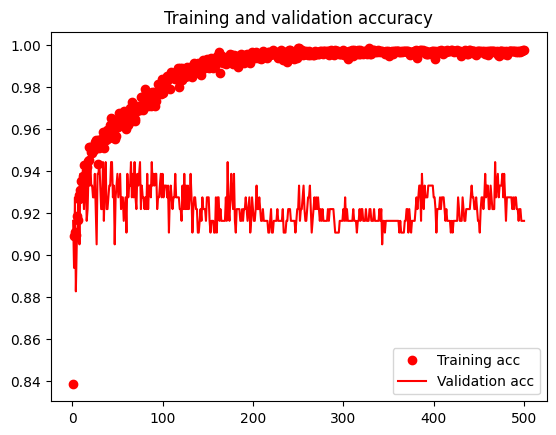

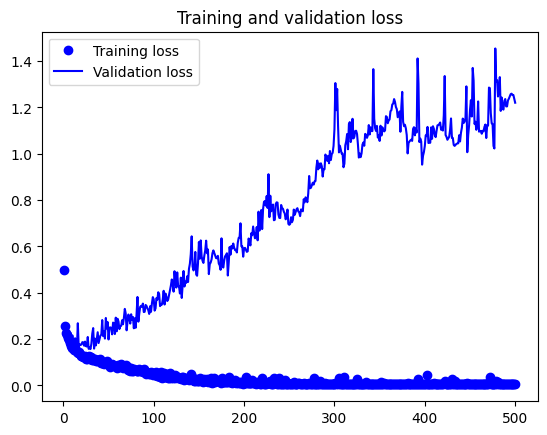

In [ ]:
# To plot the results of training
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "ro", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()
plt.savefig(f"rnn_model_{model_trained}-{model_train_date}.acc.png")
plt.show()

plt.close()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig(f"rnn_model_{model_trained}-{model_train_date}.loss.png")
plt.show()

In [24]:
# Evaluate model on the new dataset
loss, accuracy = model.evaluate(X_test, y_test)

# Print evaluation results
print("Test Generatilization Results:")
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 1s 66ms/step - loss: 1.2258 - accuracy: 0.9305
Test Generatilization Results:
Test Loss: 1.2258477210998535
Test Accuracy: 0.9304932951927185
